first we will install some dependences and import the necessary libraries

In [3]:
!pip install --upgrade astropy
!pip install --upgrade matplotlib
!pip install --upgrade scipy
!pip install --upgrade gwpy

In [1]:
import gwpy
print(gwpy.__version__)
import astropy
print(astropy.__version__)
%matplotlib inline

3.0.10
6.1.4


In [45]:
from gwosc import datasets
from gwosc.datasets import find_datasets
import matplotlib.pyplot as plt

exists some **parameters** that we can use, like: **type; events, runs, or catalogs**

the **type** parameters show the others, and you can choose one of these to filter

In [5]:
catalogs = datasets.find_datasets(type='catalogs')
catalogs

['GWTC',
 'GWTC-1-confident',
 'GWTC-1-marginal',
 'GWTC-2',
 'GWTC-2.1-auxiliary',
 'GWTC-2.1-confident',
 'GWTC-2.1-marginal',
 'GWTC-3-confident',
 'GWTC-3-marginal',
 'Initial_LIGO_Virgo',
 'O1_O2-Preliminary',
 'O3_Discovery_Papers',
 'O3_IMBH_marginal',
 'O4_Discovery_Papers']

In [6]:
events = datasets.find_datasets(type='events', catalog = 'GWTC-1-confident')
events

['GW150914-v3',
 'GW151012-v3',
 'GW151226-v2',
 'GW170104-v2',
 'GW170608-v3',
 'GW170729-v1',
 'GW170809-v1',
 'GW170814-v3',
 'GW170817-v3',
 'GW170818-v1',
 'GW170823-v1']

now we know how get some specific event, in some catalog. So we can find the **gps time** for this event and use this to plot its time series

In [12]:
from gwosc.datasets import event_gps, event_at_gps

In [14]:
gps = event_gps('GW150914-v3')
gps

1126259462.4

its possible to make the inverse process too

In [17]:
event_before = event_at_gps(1126259462.4)
event_before

'GW150914'

we have the gps time, so we need select some interval around of these time

In [20]:
segment = (int(gps)-100, int(gps)+100)
segment

(1126259362, 1126259562)

using the TimeSeries function from the gwpy.timeseries library

In [23]:
from gwpy.timeseries import TimeSeries

In [25]:
ldata = TimeSeries.fetch_open_data('L1', *segment, cache=True, verbose=True)
print(ldata)

Fetched 1 URLs from gwosc.org for [1126259362 .. 1126259562))
Reading data... [Done]
TimeSeries([-1.37598861e-18, -1.43014661e-18, -1.46035763e-18,
            ..., -9.97733204e-19, -9.91026903e-19,
            -9.85563289e-19]
           unit: dimensionless,
           t0: 1126259362.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


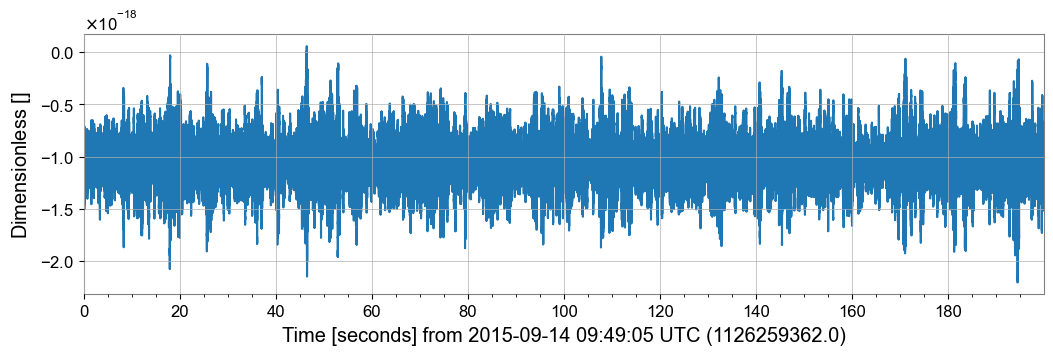

In [26]:
plot = ldata.plot()

this is our signal in interval (-100,100) around the gps time

now we will use the Hann window, a smoothing function used to avoid unwanted effects such as spectral leakage when performing Fourier transforms

**if we do not use the Hann window**, our spectrum after the transform would be as below, where the data is wider at the ends and narrower in the center

In [31]:
fft = ldata.fft()

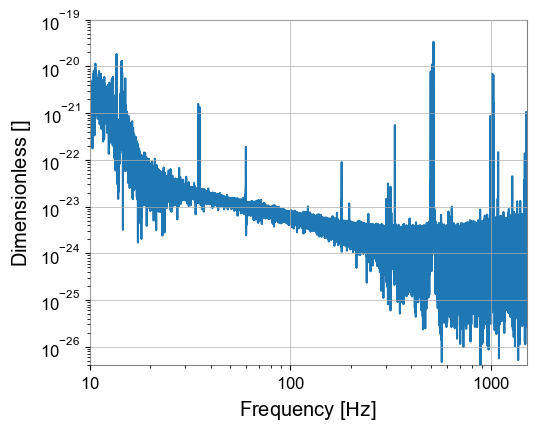

In [35]:
plot = fft.abs().plot(xscale="log", yscale="log")

axfft =plot.gca()
axfft.set_xlim(10, 1500)
axfft.set_ylim(0.4e-26,1e-19)
plot.show()

A janela de Hann é uma função matemática que suaviza as extremidades dos dados aplicando valores que vão de 0 nas bordas até 1 no centro. Isso ajuda a reduzir os efeitos de descontinuidade quando os dados são transformados, por exemplo, usando uma FFT. Sua função é da seguinte forma

$$ w_{n} = 0.5(1-cos\left(\frac{2\pi n}{N-1}\right)), \hspace{1cm} n = 0, 1, 2, ..., N-1$$

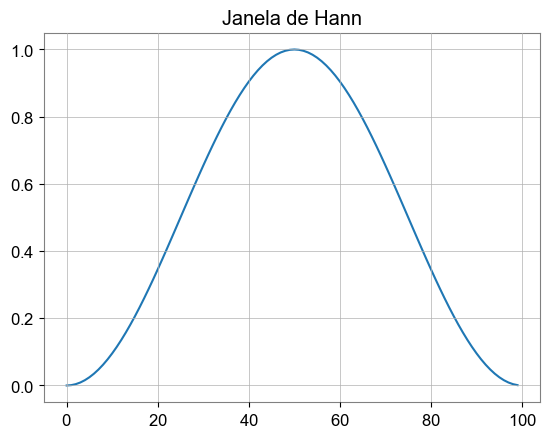

In [47]:
from scipy.signal import get_window

N = 100  # Tamanho da janela
window = get_window('hann', N)

plt.plot(window)
plt.title('Janela de Hann')
plt.show()

**So, applying the Hann window to the ( ldata )** data and subsequently the transform, we have:

In [57]:
window = get_window('hann', ldata.size)
lwin = ldata * window

now we can use the Fourier transform to smooting and cut our frequency range that we need

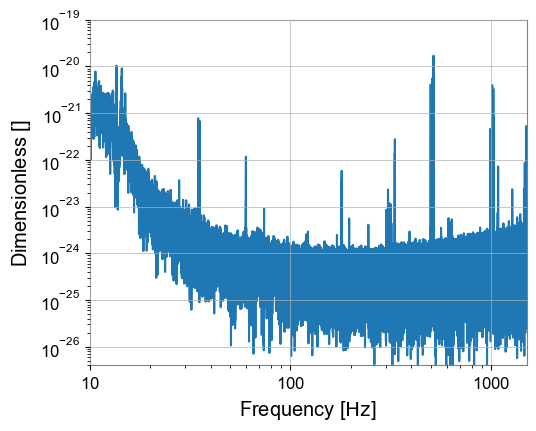

In [60]:
fftamp = lwin.fft().abs()
plot = fftamp.plot(xscale="log", yscale="log")

limfftamp = plot.gca()

# Definir os limites dos eixos
limfftamp.set_xlim(10, 1500)
limfftamp.set_ylim(0.4e-26, 1e-19)

#Mostrar o gráfico
plot.show()

Now we can see what the noises look like for this frequency range

[(15, 1500), (4e-24, 1e-20)]

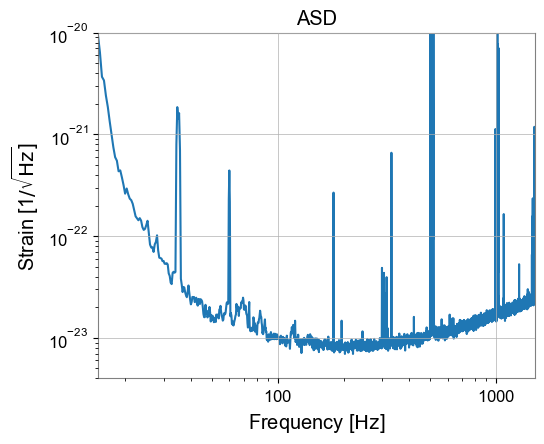

In [63]:
asd = ldata.asd(fftlength=3)
plot = asd.plot()

ax = plot.gca()
ax.set_title('ASD')
ax.set_ylabel(r'Strain [1$/\sqrt{\mathrm{Hz}}$]')
ax.set(xlim=(15, 1500), ylim=(0.4e-23, 1e-20))

the "strain" mean the amplitudes of these noises. We note that the strain noises are small than the strain from the GW, whose amplitudes order are $10^{-21}$ meters

now we will see the frequency behavior as a function of time

In [66]:
# para Hanford data
hdata2 = TimeSeries.fetch_open_data('H1', *segment, cache=True)

In [74]:
from gwosc.datasets import event_at_gps
from gwpy.timeseries import TimeSeriesBase

gps = event_gps('GW150914-v3')
print("GW150914 GPS:", gps)

segment2 = (int(gps) -16, int(gps)+16)
hdata = TimeSeries.fetch_open_data('H1', *segment2, verbose = True, cache=True )

GW150914 GPS: 1126259462.4
Fetched 1 URLs from gwosc.org for [1126259446 .. 1126259478))
Reading data... [Done]


In [ ]:
hq = hdata.q_transform(frange=(30, 500), outseg=(gps-0.2,gps+0.1))
plot = hq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")